In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"dotyushka666","key":"6d24307f539914d0b5edeab604324366"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c teta-ml-1-2025
!unzip /kaggle/working/teta-ml-1-2025.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 3.8 MB/s eta 0:00:00a 0:00:01
Archive:  /kaggle/working/teta-ml-1-2025.zip
  inflating: sample_submition.csv    
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install reverse_geocoder
!pip install usaddress-scourgify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268068 sha256=618e4f9cc8b9bde41a46768b697336c75b536748144fff575d353044c9ea2003
  Stored in directory: /root/.cache/pip/wheels/bd/e5/88/eb139b6d6a26b8022d370ab991f7a836802fed9871975ec6d9
Successfully built reverse_geocoder
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.4 MB/s eta 0:00:00a 0:00:01


# Оглавление
* [1. Исследовательский анализ данных (EDA)](#chapter_1)
    * [1.1 Первичный анализ данных](#chapter_1_1)

In [4]:
import re

import usaddress
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import reverse_geocoder as rg
import seaborn as sns
import shap
import torch
from catboost import CatBoostClassifier
from geopy.distance import great_circle
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

In [5]:
RANDOM_STATE = 64

In [88]:
df_fraud = pd.read_csv("train.csv")
df_fraud.head()

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target
0,2019-12-27 15:21,fraud_Cormier LLC,health_fitness,148.04,Daniel,Martinez,M,8510 Acevedo Burgs,Kent,OR,97033,45.0838,-120.6649,60,Museum education officer,45.042827,-120.709327,0
1,2019-04-17 23:09,"fraud_Brown, Homenick and Lesch",health_fitness,39.40,Grace,Williams,F,28812 Charles Mill Apt. 628,Plantersville,AL,36758,32.6176,-86.9475,1412,Drilling engineer,31.872266,-87.828247,0
2,2019-09-23 15:02,fraud_Ruecker-Mayert,kids_pets,52.96,Kyle,Park,M,7507 Larry Passage Suite 859,Mount Perry,OH,43760,39.8788,-82.1880,1831,Barrister's clerk,40.010874,-81.841249,0
3,2019-05-13 16:00,"fraud_Mante, Luettgen and Hackett",health_fitness,7.66,Monique,Martin,F,68276 Matthew Springs,Ratcliff,TX,75858,31.3833,-95.0619,43,"Engineer, production",30.888406,-95.141609,0
4,2019-08-18 07:27,fraud_Luettgen PLC,gas_transport,51.59,Christine,Johnson,F,8011 Chapman Tunnel Apt. 568,Blairsden-Graeagle,CA,96103,39.8127,-120.6405,1725,Chartered legal executive (England and Wales),39.376017,-121.311691,0


## 1. Исследовательский анализ данных (EDA) <a class="anchor" id="chapter_1"></a>
### 1.1. Первичный анализ данных <a id="chapter_1_1"></a>

In [5]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786431 entries, 0 to 786430
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_time  786431 non-null  object 
 1   merch             786431 non-null  object 
 2   cat_id            786431 non-null  object 
 3   amount            786431 non-null  float64
 4   name_1            786431 non-null  object 
 5   name_2            786431 non-null  object 
 6   gender            786431 non-null  object 
 7   street            786431 non-null  object 
 8   one_city          786431 non-null  object 
 9   us_state          786431 non-null  object 
 10  post_code         786431 non-null  int64  
 11  lat               786431 non-null  float64
 12  lon               786431 non-null  float64
 13  population_city   786431 non-null  int64  
 14  jobs              786431 non-null  object 
 15  merchant_lat      786431 non-null  float64
 16  merchant_lon      78

In [6]:
print("Данные, которые содержат дубликаты:")
df_fraud[df_fraud.duplicated()]

Данные, которые содержат дубликаты:


,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target


Пропущенные значения в каждом столбце:
transaction_time    0
merch               0
cat_id              0
amount              0
name_1              0
name_2              0
gender              0
street              0
one_city            0
us_state            0
post_code           0
lat                 0
lon                 0
population_city     0
jobs                0
merchant_lat        0
merchant_lon        0
target              0
dtype: int64


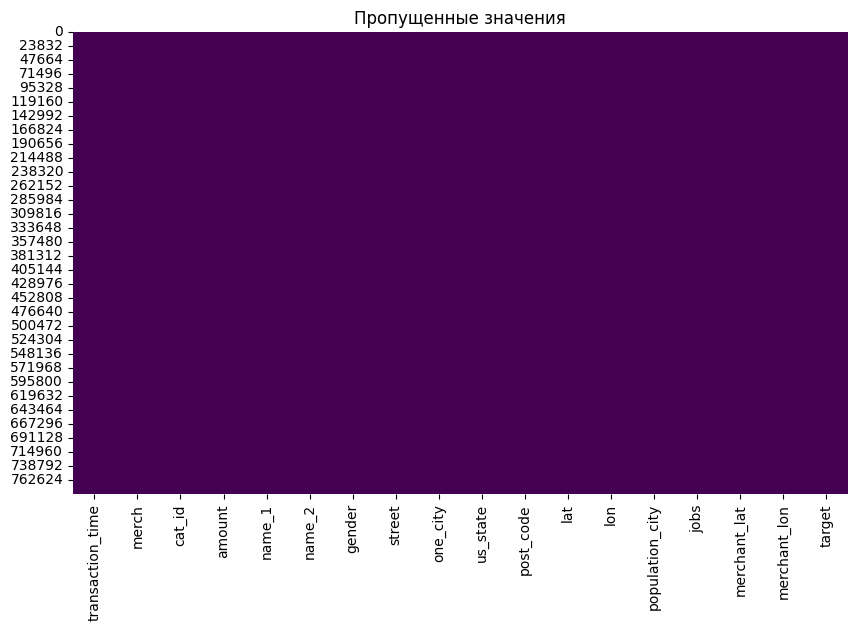

In [ ]:
missing_values = df_fraud.isnull().sum()

print("Пропущенные значения в каждом столбце:")
print(missing_values)

plt.figure(figsize=(10, 6))
sns.heatmap(df_fraud.isnull(), cbar=False, cmap="viridis")
plt.title("Пропущенные значения")
plt.show()

In [10]:
df_fraud.describe()

,amount,post_code,lat,lon,population_city,merchant_lat,merchant_lon,target
count,786431.000000,786431.000000,786431.000000,786431.000000,7.864310e+05,786431.000000,786431.000000,786431.000000
mean,70.241296,48802.521336,38.527972,-90.224069,8.928853e+04,38.527301,-90.224508,0.005727
std,161.091489,26896.564152,5.078756,13.754760,3.028600e+05,5.113222,13.766977,0.075461
min,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,19.027804,-166.670132,0.000000
25%,9.650000,26237.000000,34.620500,-96.798000,7.430000e+02,34.727480,-96.901593,0.000000
50%,47.410000,48174.000000,39.346500,-87.476900,2.456000e+03,39.357665,-87.436919,0.000000
75%,83.000000,72042.000000,41.894800,-80.158000,2.047800e+04,41.950609,-80.233429,0.000000
max,27390.120000,99783.000000,66.693300,-67.950300,2.906700e+06,67.441518,-66.955996,1.000000


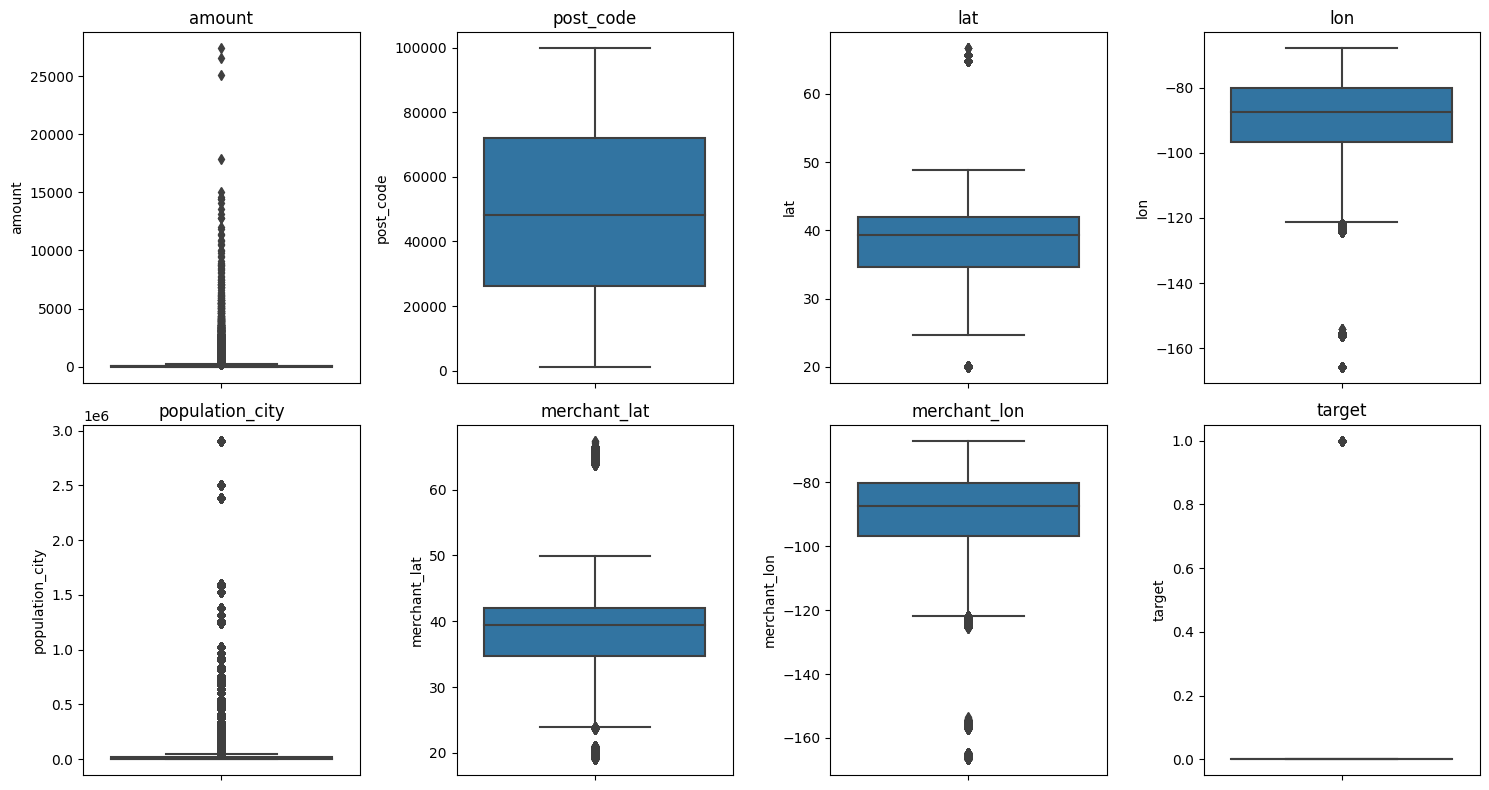

In [ ]:
numerical_columns = df_fraud.select_dtypes(include=["float64", "int64"]).columns

plt.figure(figsize=(15, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df_fraud[column])
    plt.title(column)
plt.tight_layout()
plt.show()

In [ ]:
categorical_columns = df_fraud.select_dtypes(include=["object"]).columns

print("Уникальные значения в категориальных признаках:")
for column in categorical_columns:
    print(f"{column}: {df_fraud[column].nunique()} уникальных значений")
    print(df_fraud[column].value_counts())
    print("\n")

Уникальные значения в категориальных признаках:
transaction_time: 419851 уникальных значений
transaction_time
2019-12-01 19:27    15
2019-12-22 20:43    14
2019-12-14 23:08    12
2019-12-29 21:43    12
2019-12-23 18:35    12
                    ..
2020-02-05 09:20     1
2019-04-22 10:56     1
2019-05-15 11:23     1
2019-02-05 12:28     1
2019-10-10 16:51     1
Name: count, Length: 419851, dtype: int64


merch: 693 уникальных значений
merch
fraud_Kilback LLC                       2659
fraud_Cormier LLC                       2256
fraud_Schumm PLC                        2209
fraud_Boyer PLC                         2130
fraud_Kuhn LLC                          2113
                                        ... 
fraud_Medhurst, Labadie and Gottlieb     465
fraud_Hahn, Douglas and Schowalter       458
fraud_Reichert-Weissnat                  457
fraud_Satterfield-Lowe                   454
fraud_Kilback, Nitzsche and Leffler      449
Name: count, Length: 693, dtype: int64


cat_id: 14 уникальны

In [11]:
df_fraud["target"].value_counts(normalize=True)

target
0    0.994273
1    0.005727
Name: proportion, dtype: float64

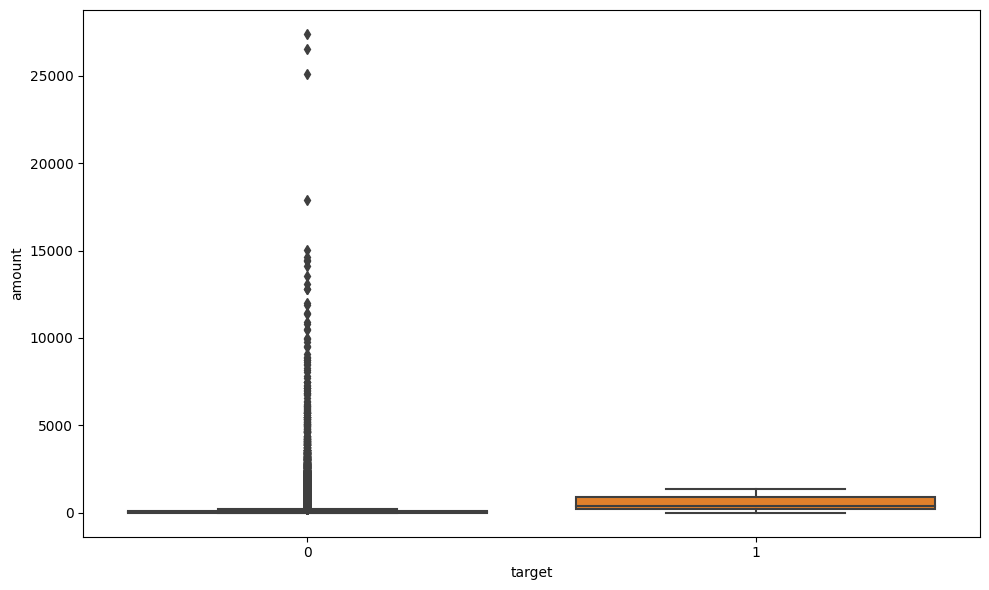

In [22]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=df_fraud, y="amount", x="target")

plt.tight_layout()
plt.show()

## Построение моделей

### Baseline *(public F1 = 0.829646)*

In [4]:
def calculate_distance(row):
    client_coords = (row["lat"], row["lon"])
    merchant_coords = (row["merchant_lat"], row["merchant_lon"])
    return great_circle(client_coords, merchant_coords).km


def preprocessing_data_baseline(df_fraud: pd.DataFrame):
    df_train = df_fraud.drop(columns=["name_1", "name_2", "street", "one_city", "jobs"])

    df_train["post_code"] = df_train["post_code"] // 10

    df_train["population_city"] = np.log(df_train["population_city"] + 1)

    df_train["transaction_time"] = pd.to_datetime(df_train["transaction_time"])
    df_train["hour"] = df_train["transaction_time"].dt.hour
    df_train["days_in_month"] = df_train["transaction_time"].dt.days_in_month
    df_train["day_of_week"] = df_train["transaction_time"].dt.dayofweek

    df_train.drop("transaction_time", axis=1, inplace=True)

    df_train["distance_km"] = df_train.apply(calculate_distance, axis=1)
    df_train.drop(["lat", "lon", "merchant_lat", "merchant_lon"], axis=1, inplace=True)

    cat_features = ["merch", "cat_id", "gender", "us_state"]
    df_train = pd.get_dummies(df_train, columns=cat_features, drop_first=True)

    return df_train

In [ ]:
df_train = preprocessing_data_baseline(df_fraud)

X = df_train.drop("target", axis=1)
y = df_train["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

In [ ]:
evalset = [(X_train, y_train), (X_test, y_test)]

xgbclf = XGBClassifier(
    learning_rate=0.3,
    n_estimators=256,
    max_depth=8,
    objective="binary:logistic",
    eval_metric="auc",
    early_stopping_rounds=5,
)

xgbclf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [88]:
xgbclf.fit(X_train, y_train, eval_set=evalset)

[0]	validation_0-auc:0.97290	validation_1-auc:0.97670
[1]	validation_0-auc:0.97321	validation_1-auc:0.97706
[2]	validation_0-auc:0.97363	validation_1-auc:0.97727
[3]	validation_0-auc:0.97373	validation_1-auc:0.97739
[4]	validation_0-auc:0.97455	validation_1-auc:0.97853
[5]	validation_0-auc:0.98975	validation_1-auc:0.99124
[6]	validation_0-auc:0.99036	validation_1-auc:0.99239
[7]	validation_0-auc:0.99369	validation_1-auc:0.99362
[8]	validation_0-auc:0.99435	validation_1-auc:0.99382
[9]	validation_0-auc:0.99523	validation_1-auc:0.99433
[10]	validation_0-auc:0.99578	validation_1-auc:0.99421
[11]	validation_0-auc:0.99597	validation_1-auc:0.99443
[12]	validation_0-auc:0.99625	validation_1-auc:0.99447
[13]	validation_0-auc:0.99680	validation_1-auc:0.99534
[14]	validation_0-auc:0.99699	validation_1-auc:0.99494
[15]	validation_0-auc:0.99748	validation_1-auc:0.99570
[16]	validation_0-auc:0.99752	validation_1-auc:0.99601
[17]	validation_0-auc:0.99763	validation_1-auc:0.99608
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [89]:
y_pred = xgbclf.predict(X_test)
y_proba = xgbclf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    156386
           1       0.88      0.73      0.80       901

    accuracy                           1.00    157287
   macro avg       0.94      0.86      0.90    157287
weighted avg       1.00      1.00      1.00    157287

ROC-AUC: 0.99712065224422


In [ ]:
importance_features = pd.DataFrame(
    data={"features": X_train.columns.to_list(), "score": xgbclf.feature_importances_}
)

In [120]:
importance_features.sort_values("score", ascending=False).head(10)

,features,score
702,cat_id_grocery_pos,0.348264
700,cat_id_gas_transport,0.184555
0,amount,0.037068
3,hour,0.028519
701,cat_id_grocery_net,0.018477
711,cat_id_travel,0.015090
706,cat_id_misc_net,0.014236
735,us_state_MN,0.013899
704,cat_id_home,0.009837
707,cat_id_misc_pos,0.009467


In [121]:
xgbclf.fit(X, y, eval_set=[(X, y)])

[0]	validation_0-auc:0.97330
[1]	validation_0-auc:0.97405
[2]	validation_0-auc:0.97593
[3]	validation_0-auc:0.97615
[4]	validation_0-auc:0.98903
[5]	validation_0-auc:0.99112
[6]	validation_0-auc:0.99157
[7]	validation_0-auc:0.99181
[8]	validation_0-auc:0.99462
[9]	validation_0-auc:0.99545
[10]	validation_0-auc:0.99596
[11]	validation_0-auc:0.99607
[12]	validation_0-auc:0.99615
[13]	validation_0-auc:0.99662
[14]	validation_0-auc:0.99695
[15]	validation_0-auc:0.99744
[16]	validation_0-auc:0.99782
[17]	validation_0-auc:0.99786
[18]	validation_0-auc:0.99795
[19]	validation_0-auc:0.99803
[20]	validation_0-auc:0.99810
[21]	validation_0-auc:0.99826
[22]	validation_0-auc:0.99836
[23]	validation_0-auc:0.99842
[24]	validation_0-auc:0.99853
[25]	validation_0-auc:0.99862
[26]	validation_0-auc:0.99866
[27]	validation_0-auc:0.99869
[28]	validation_0-auc:0.99874
[29]	validation_0-auc:0.99876
[30]	validation_0-auc:0.99877
[31]	validation_0-auc:0.99882
[32]	validation_0-auc:0.99884
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Предсказания на тестовой выборке

In [122]:
df_fraud_test = pd.read_csv("test.csv")
df_fraud_test.head()

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon
0,2019-09-14 02:46,"fraud_Stokes, Christiansen and Sipes",grocery_net,25.79,Michael,Rodriguez,M,172 Paula Inlet Apt. 650,Cross Plains,TX,76443,32.1482,-99.1872,1897,Chief Operating Officer,31.772057,-99.103183
1,2019-07-25 20:30,fraud_Thompson-Gleason,health_fitness,87.80,Curtis,Young,M,4319 Watson Shoals Suite 658,Falconer,NY,14733,42.1239,-79.1895,3833,Metallurgist,42.635312,-78.334559
2,2020-01-05 17:27,fraud_Friesen Inc,shopping_pos,10.98,Brandy,Quinn,F,9734 Beard Fields Suite 885,Altair,TX,77412,29.6047,-96.5249,106,"Editor, film/video",29.363782,-95.624994
3,2019-07-21 00:14,"fraud_Jenkins, Hauck and Friesen",gas_transport,71.97,Ashley,Mcdonald,F,3160 Tina Estates Suite 234,Marietta,SC,29661,35.0296,-82.5136,5648,Museum/gallery exhibitions officer,35.142659,-82.489028
4,2019-03-13 00:45,"fraud_Kovacek, Dibbert and Ondricka",grocery_pos,210.50,Kimberly,Rice,F,63991 Destiny Rue Apt. 651,Tyler,TX,75703,32.2768,-95.3031,144160,Sports development officer,31.833016,-94.746542


In [123]:
df_test = preprocessing_data_baseline(df_fraud_test)

In [124]:
assert df_test.shape[1] == df_train.shape[1] - 1

In [125]:
y_proba_test = xgbclf.predict_proba(df_test)[:, 1]

In [126]:
df_predict_test = pd.DataFrame(y_proba_test, columns=["prediction"]).reset_index()
df_predict_test["prediction"] = df_predict_test["prediction"].apply(
    lambda x: 1 if x >= 0.5 else 0
)

In [127]:
df_predict_test.to_csv("baseline_xgboost_2.csv", index=None)

## Catboost со всеми категориальными фичами *(public F1 = 0.864225)*

In [8]:
def preprocessing_data_catboost(df_fraud: pd.DataFrame):
    df_train = df_fraud.copy(deep=True)

    df_train["post_code"] = df_train["post_code"] // 10

    df_train["population_city"] = np.log(df_train["population_city"] + 1)

    df_train["transaction_time"] = pd.to_datetime(df_train["transaction_time"])
    df_train["hour"] = df_train["transaction_time"].dt.hour
    df_train["days_in_month"] = df_train["transaction_time"].dt.days_in_month
    df_train["day_of_week"] = df_train["transaction_time"].dt.dayofweek

    df_train.drop("transaction_time", axis=1, inplace=True)

    df_train["distance_km"] = df_train.apply(calculate_distance, axis=1)
    df_train.drop(["lat", "lon", "merchant_lat", "merchant_lon"], axis=1, inplace=True)

    return df_train

In [9]:
df_train = preprocessing_data_catboost(df_fraud)

X = df_train.drop("target", axis=1)
y = df_train["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

In [ ]:
cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

In [ ]:
catbclf = CatBoostClassifier(
    iterations=256,
    learning_rate=0.04,
    depth=8,
    eval_metric="AUC",
    early_stopping_rounds=50,
    verbose=30,
    cat_features=cat_features,
    random_state=RANDOM_STATE,
)

In [16]:
catbclf.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	test: 0.8695596	best: 0.8695596 (0)	total: 563ms	remaining: 2m 23s
30:	test: 0.9778774	best: 0.9788825 (17)	total: 23.7s	remaining: 2m 51s
60:	test: 0.9829800	best: 0.9829864 (59)	total: 52.3s	remaining: 2m 47s
90:	test: 0.9857370	best: 0.9857370 (90)	total: 1m 20s	remaining: 2m 25s
120:	test: 0.9891987	best: 0.9891987 (120)	total: 1m 48s	remaining: 2m 1s
150:	test: 0.9913042	best: 0.9913042 (150)	total: 2m 17s	remaining: 1m 35s
180:	test: 0.9923619	best: 0.9923619 (180)	total: 2m 47s	remaining: 1m 9s
210:	test: 0.9931158	best: 0.9931158 (210)	total: 3m 16s	remaining: 41.8s
240:	test: 0.9934440	best: 0.9934440 (240)	total: 3m 45s	remaining: 14.1s
255:	test: 0.9937395	best: 0.9937395 (255)	total: 4m	remaining: 0us

bestTest = 0.9937394727
bestIteration = 255



In [17]:
y_pred = catbclf.predict(X_test)
y_proba = catbclf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    156386
           1       0.94      0.77      0.85       901

    accuracy                           1.00    157287
   macro avg       0.97      0.89      0.92    157287
weighted avg       1.00      1.00      1.00    157287

ROC-AUC: 0.9937394726923803


In [ ]:
importance_features_ctb = pd.DataFrame(
    data={
        "features": X_train.columns.to_list(),
        "score": catbclf.get_feature_importance(),
    }
)

In [25]:
importance_features_ctb.sort_values(by="score", ascending=False)

,features,score
12,hour,34.571513
2,amount,29.510327
1,cat_id,17.371041
6,street,4.332758
5,gender,3.466023
0,merch,3.285604
10,population_city,3.239131
14,day_of_week,0.721445
7,one_city,0.647673
3,name_1,0.592997


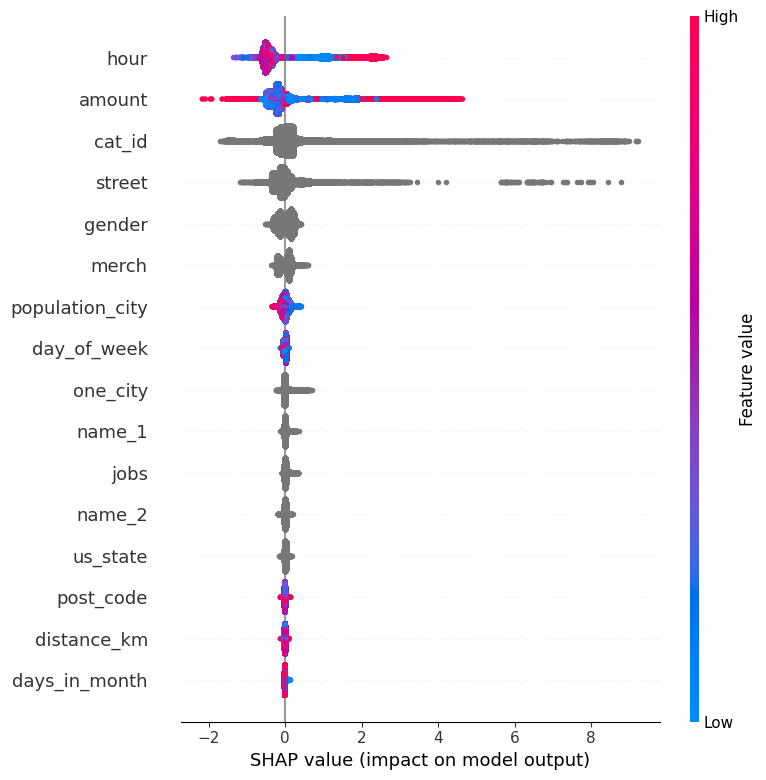

In [22]:
explainer = shap.TreeExplainer(catbclf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [26]:
catbclf.fit(X, y)

0:	total: 496ms	remaining: 2m 6s
30:	total: 26.9s	remaining: 3m 15s
60:	total: 57.6s	remaining: 3m 4s
90:	total: 1m 28s	remaining: 2m 40s
120:	total: 1m 59s	remaining: 2m 13s
150:	total: 2m 31s	remaining: 1m 45s
180:	total: 3m 2s	remaining: 1m 15s
210:	total: 3m 33s	remaining: 45.6s
240:	total: 4m 5s	remaining: 15.3s
255:	total: 4m 21s	remaining: 0us


### Предсказание на тестовой выборке

In [ ]:
df_fraud_test = pd.read_csv("test.csv")

df_test = preprocessing_data_catboost(df_fraud_test)
assert df_test.shape[1] == df_train.shape[1] - 1

y_proba_test = catbclf.predict_proba(df_test)[:, 1]

In [29]:
df_predict_test = pd.DataFrame(y_proba_test, columns=["prediction"]).reset_index()
df_predict_test["prediction"] = df_predict_test["prediction"].apply(
    lambda x: 1 if x >= 0.5 else 0
)

In [30]:
df_predict_test.to_csv("catboost_full_features.csv", index=None)

## Предыдущий Catboost с добавлением новых фичей *(public F1=0.893429) без parse address и временных фич*
После добавления временных фич и parse adderess (дает прирост номер улицы) *public F1=0.931126*

In [ ]:
import torch
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")


def get_bert_embedding(job):
    inputs = tokenizer(job, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [17]:
from functools import lru_cache

In [ ]:
@lru_cache(maxsize=128)
def calculate_distance(row_client: tuple[float], merchant_coords: tuple[float]):
    return great_circle(row_client, merchant_coords).km


@lru_cache(maxsize=256)
def get_info_coord(coord: tuple[tuple]):
    try:
        location = rg.search(coord)
        return location
    except:
        return {}


@lru_cache(maxsize=256)
def parse_address(address: str):
    try:
        parsed = usaddress.tag(address)[0]
        return {
            "street_number": parsed.get("AddressNumber", -1),
            "street_name": parsed.get("StreetName", "unk"),
            "street_suffix": parsed.get("StreetNamePostType", "unk"),
            "apartment": int(parsed.get("OccupancyIdentifier", -1)),
            "occupancy_identifier": parsed.get("OccupancyType", "unk"),
        }
    except:
        return {
            "street_number": -1,
            "street_name": "unk",
            "street_suffix": "unk",
            "apartment": -1,
            "occupancy_identifier": "unk",
        }

In [ ]:
def preprocessing_data_catboost_v2(df_fraud: pd.DataFrame):
    df_train = df_fraud.copy(deep=True)
    df_train = df_train.sort_values("transaction_time").reset_index(drop=True)

    df_train["population_city"] = np.log(df_train["population_city"] + 1)
    df_train["is_round_amount"] = df_train["amount"].apply(lambda x: not bool(x % 10))
    df_train["amount"] = np.log(df_train["amount"] + 1)

    df_train["user_cumsum"] = df_train.groupby(
        by=["name_1", "name_2", "one_city", "us_state", "post_code"]
    )["amount"].cumsum()
    df_train["user_cumcount"] = (
        df_train.groupby(by=["name_1", "name_2", "one_city", "us_state", "post_code"])[
            "amount"
        ].cumcount()
        + 1
    )

    df_train["user_mean_amount_7_prev"] = (
        df_train.groupby(by=["name_1", "name_2", "one_city", "us_state", "post_code"])[
            "amount"
        ]
        .rolling(7)
        .mean()
        .values
    )
    df_train["user_mean_amount_7_prev"] = df_train["user_mean_amount_7_prev"].fillna(-1)

    df_train["user_mean_amount_30_prev"] = (
        df_train.groupby(by=["name_1", "name_2", "one_city", "us_state", "post_code"])[
            "amount"
        ]
        .rolling(30)
        .mean()
        .values
    )
    df_train["user_mean_amount_30_prev"] = df_train["user_mean_amount_30_prev"].fillna(
        -1
    )

    df_train["user_avg_amount"] = df_train["user_cumsum"] / df_train["user_cumcount"]

    df_train["mean_amount_merch_30_prev"] = (
        df_train.groupby("merch")["amount"].rolling(30).mean().values
    )
    df_train["mean_amount_merch_30_prev"] = df_train[
        "mean_amount_merch_30_prev"
    ].fillna(-1)

    df_train["std_amount_merch_30_prev"] = (
        df_train.groupby("merch")["amount"].rolling(30).std().values
    )
    df_train["std_amount_merch_30_prev"] = df_train["std_amount_merch_30_prev"].fillna(
        -1
    )

    df_train["mean_amount_cat_30_prev"] = (
        df_train.groupby("cat_id")["amount"].rolling(30).mean().values
    )
    df_train["mean_amount_cat_30_prev"] = df_train["mean_amount_cat_30_prev"].fillna(-1)

    df_train["std_amount_cat_30_prev"] = (
        df_train.groupby("cat_id")["amount"].rolling(30).std().values
    )
    df_train["std_amount_cat_30_prev"] = df_train["std_amount_cat_30_prev"].fillna(-1)

    df_train["prev_amount"] = df_train.groupby(
        by=["name_1", "name_2", "one_city", "us_state", "post_code"]
    )["amount"].shift(1)
    df_train["prev_amount"] = df_train["prev_amount"].fillna(-1)

    df_train["prev_two_amount"] = df_train.groupby(
        by=["name_1", "name_2", "one_city", "us_state", "post_code"]
    )["amount"].shift(2)
    df_train["prev_two_amount"] = df_train["prev_two_amount"].fillna(-1)

    df_train["prev_three_amount"] = df_train.groupby(
        by=["name_1", "name_2", "one_city", "us_state", "post_code"]
    )["amount"].shift(3)
    df_train["prev_three_amount"] = df_train["prev_three_amount"].fillna(-1)

    df_train["prev_four_amount"] = df_train.groupby(
            by=["name_1", "name_2", "one_city", "us_state", "post_code"]
        )["amount"].shift(4)
    df_train["prev_four_amount"] = df_train["prev_four_amount"].fillna(-1)

    df_train["prev_cat_id"] = df_train.groupby(
        by=["name_1", "name_2", "one_city", "us_state", "post_code"]
    )["cat_id"].shift(1)
    df_train["prev_cat_id"] = df_train["prev_cat_id"].fillna("unk")

    # df_train["post_code"] = df_train["post_code"] // 100

    df_train["transaction_time"] = pd.to_datetime(df_train["transaction_time"])
    df_train["hour"] = df_train["transaction_time"].dt.hour
    df_train["part_of_day"] = pd.cut(
        df_train["hour"],
        bins=[-1, 6, 12, 18, 24],
        labels=["night", "morning", "afternoon", "evening"],
    )
    df_train["year"] = df_train["transaction_time"].dt.year
    df_train["month"] = df_train["transaction_time"].dt.month
    df_train["day_of_month"] = df_train["transaction_time"].dt.day
    df_train["day_of_week"] = df_train["transaction_time"].dt.dayofweek

    # df_street_info = pd.DataFrame(df_train["street"], columns=im)

    df_train = df_train.join(
        df_train["street"].apply(lambda x: pd.Series(parse_address(x)))
    )

    df_train["job_title_length"] = df_train["jobs"].str.len()

    df_train["distance_km_in_table_info"] = df_train.apply(
        lambda x: calculate_distance(
            (x["lat"], x["lon"]), (x["merchant_lat"], x["merchant_lon"])
        ),
        axis=1,
    )

    uniq_coord = tuple(df_train[["lat", "lon"]].itertuples(index=False, name=None))
    merchant_uniq_coord = tuple(
        df_train[["merchant_lat", "merchant_lon"]].itertuples(index=False, name=None)
    )

    dict_coords = get_info_coord(uniq_coord)
    merchant_dict_coords = get_info_coord(merchant_uniq_coord)

    coords = pd.DataFrame(dict_coords)
    coords = coords.rename(
        columns={
            "lat": "lat_coords",
            "lon": "lon_coords",
            "name": "name_coords",
            "admin1": "admin1_coords",
            "admin2": "admin2_coords",
            "cc": "cc_coords",
        }
    )
    coords = coords[["name_coords", "admin2_coords"]]

    merchant_coords = pd.DataFrame(merchant_dict_coords)
    merchant_coords = merchant_coords.rename(
        columns={
            "lat": "merchant_lat_coords",
            "lon": "merchant_lon_coords",
            "name": "merchant_name_coords",
            "admin1": "merchant_admin1_coords",
            "admin2": "merchant_admin2_coords",
            "cc": "merchant_cc_coords",
        }
    )
    merchant_coords = merchant_coords[
        ["merchant_name_coords", "merchant_admin2_coords"]
    ]

    df_train = pd.concat([df_train, coords], axis=1)
    df_train = pd.concat([df_train, merchant_coords], axis=1)

    df_train["is_out_of_county"] = (
        df_train["admin2_coords"] != df_train["merchant_admin2_coords"]
    ).astype(int)
    df_train["is_out_of_name"] = (
        df_train["name_coords"] != df_train["merchant_name_coords"]
    ).astype(int)

    # df_train['job_embedding'] = df_train['jobs'].apply(get_bert_embedding)

    df_train.drop(
        [
            "lat",
            "lon",
            "merchant_lat",
            "merchant_lon",
            "admin2_coords",
            "merchant_admin2_coords",
            "name_coords",
            "merchant_name_coords",
            "transaction_time",
            "street",
        ],
        axis=1,
        inplace=True,
    )

    return df_train

In [92]:
df_train = preprocessing_data_catboost_v2(df_fraud)

df_train.head()

,merch,cat_id,amount,name_1,name_2,gender,one_city,us_state,post_code,population_city,...,day_of_week,street_number,street_name,street_suffix,apartment,occupancy_identifier,job_title_length,distance_km_in_table_info,is_out_of_county,is_out_of_name
0,"fraud_Heller, Gutmann and Zieme",grocery_pos,4.684259,Stephanie,Gill,F,Orient,WA,99160,5.010635,...,1,43039,Riley,Greens,393,Suite,33,30.212218,0,0
1,fraud_Keeling-Crist,misc_pos,3.760269,Tyler,Garcia,M,Doe Hill,VA,24433,4.605170,...,1,408,Bradley,Rest,-1,unk,30,77.556853,1,1
2,fraud_Rowe-Vandervort,grocery_net,3.818591,Kelsey,Richards,F,Holcomb,KS,67851,7.898040,...,1,889,Sarah,Station,624,Suite,15,118.119942,1,1
3,"fraud_Stroman, Hudson and Erdman",gas_transport,4.560487,Jennifer,Conner,F,Dublin,PA,18917,7.677400,...,1,4655,David,Island,-1,unk,17,85.922764,1,1
4,fraud_Herzog Ltd,misc_pos,1.662030,Heather,Chase,F,Manor,PA,15665,7.295056,...,1,6888,Hicks,Stream,954,Suite,25,25.270529,1,1


In [93]:
df_train.columns

Index(['merch', 'cat_id', 'amount', 'name_1', 'name_2', 'gender', 'one_city',
       'us_state', 'post_code', 'population_city', 'jobs', 'target',
       'is_round_amount', 'user_cumsum', 'user_cumcount',
       'user_mean_amount_7_prev', 'user_mean_amount_30_prev',
       'user_avg_amount', 'mean_amount_merch_30_prev',
       'std_amount_merch_30_prev', 'mean_amount_cat_30_prev',
       'std_amount_cat_30_prev', 'prev_amount', 'prev_two_amount',
       'prev_three_amount', 'prev_four_amount', 'prev_cat_id', 'hour',
       'part_of_day', 'month', 'day_of_month', 'day_of_week', 'street_number',
       'street_name', 'street_suffix', 'apartment', 'occupancy_identifier',
       'job_title_length', 'distance_km_in_table_info', 'is_out_of_county',
       'is_out_of_name'],
      dtype='object')

Index(['merch', 'cat_id', 'amount', 'name_1', 'name_2', 'gender', 'one_city',
       'us_state', 'post_code', 'population_city', 'jobs', 'target',
       'is_round_amount', 'user_cumsum', 'user_cumcount', 'user_avg_amount',
       'mean_amount_merch_30_prev', 'mean_amount_cat_30_prev', 'prev_amount',
       'hour', 'part_of_day', 'month', 'day_of_month', 'day_of_week',
       'street_number', 'street_name', 'job_title_length',
       'distance_km_in_table_info', 'is_out_of_county', 'is_out_of_name'],
      dtype='object')

Index(['merch', 'cat_id', 'amount', 'name_1', 'name_2', 'gender', 'one_city',
       'us_state', 'post_code', 'population_city', 'jobs', 'target',
       'is_round_amount', 'hour', 'part_of_day', 'month', 'day_of_month',
       'day_of_week', 'street_number', 'street_name', 'job_title_length',
       'distance_km', 'is_out_of_county', 'is_out_of_name'],
      dtype='object')

In [94]:
X = df_train.drop("target", axis=1)
y = df_train["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

In [95]:
text_features = ["jobs"]

cat_features = [
    column
    for column in X_train.select_dtypes(include=["object", "category"]).columns.tolist()
    if column not in text_features
]

In [96]:
catbclf = CatBoostClassifier(
    iterations=1024,
    learning_rate=0.06,
    depth=10,
    eval_metric="TotalF1:average=Macro",
    early_stopping_rounds=50,
    verbose=30,
    cat_features=cat_features,
    text_features=text_features,
    # bootstrap_type="MVS",
    subsample=0.8,
    random_state=RANDOM_STATE,
    task_type="CPU",
)

In [97]:
catbclf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	learn: 0.4985642	test: 0.4985638	best: 0.4985638 (0)	total: 2.05s	remaining: 34m 54s
30:	learn: 0.9358173	test: 0.9334452	best: 0.9334452 (30)	total: 1m 37s	remaining: 51m 58s
60:	learn: 0.9590721	test: 0.9498549	best: 0.9501868 (58)	total: 3m 14s	remaining: 51m 8s
90:	learn: 0.9670373	test: 0.9574387	best: 0.9574387 (88)	total: 4m 43s	remaining: 48m 29s
120:	learn: 0.9713853	test: 0.9599613	best: 0.9599613 (108)	total: 6m 7s	remaining: 45m 39s
150:	learn: 0.9749061	test: 0.9609655	best: 0.9618750 (144)	total: 7m 28s	remaining: 43m 10s
180:	learn: 0.9777177	test: 0.9628268	best: 0.9631003 (178)	total: 8m 51s	remaining: 41m 15s
210:	learn: 0.9804317	test: 0.9646794	best: 0.9646794 (210)	total: 10m 15s	remaining: 39m 31s
240:	learn: 0.9815491	test: 0.9649941	best: 0.9649941 (222)	total: 11m 38s	remaining: 37m 48s
270:	learn: 0.9832474	test: 0.9659756	best: 0.9659756 (270)	total: 12m 59s	remaining: 36m 5s
300:	learn: 0.9841282	test: 0.9659361	best: 0.9662494 (271)	total: 14m 18s	remain

In [98]:
y_pred = catbclf.predict(X_test)
y_proba = catbclf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    156386
           1       0.98      0.89      0.94       901

    accuracy                           1.00    157287
   macro avg       0.99      0.95      0.97    157287
weighted avg       1.00      1.00      1.00    157287

ROC-AUC: 0.9985834234432849


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    156386
           1       0.98      0.88      0.93       901

    accuracy                           1.00    157287
   macro avg       0.99      0.94      0.96    157287
weighted avg       1.00      1.00      1.00    157287

ROC-AUC: 0.9988993198522005



             precision    recall  f1-score   support

           0       1.00      1.00      1.00    156386
           1       0.97      0.78      0.86       901

    accuracy                           1.00    157287
   macro avg       0.98      0.89      0.93    157287
weighted avg       1.00      1.00      1.00    157287

ROC-AUC: 0.9964549355685872

In [99]:
importance_features_ctb = pd.DataFrame(
    data={
        "features": X_train.columns.to_list(),
        "score": catbclf.get_feature_importance(),
    }
)

importance_features_ctb.sort_values(by="score", ascending=False)

,features,score
2,amount,22.085587
26,hour,17.899601
1,cat_id,15.966593
21,prev_amount,6.487196
27,part_of_day,4.626144
22,prev_two_amount,4.551679
16,user_avg_amount,4.535132
31,street_number,2.581473
23,prev_three_amount,2.360688
9,population_city,2.206269


In [100]:
X_test_post = X_test.copy(deep=True)
X_test_post["target"] = y_test

In [101]:
X_test_post["predicted"] = y_pred
X_test_post["prob"] = y_proba
X_test_post["wrong_pred"] = X_test_post["predicted"] != X_test_post["target"]

In [102]:
df_errors = X_test_post[X_test_post["wrong_pred"]]
df_errors = df_errors.sort_values(by="prob", ascending=False)

In [103]:
df_errors

,merch,cat_id,amount,name_1,name_2,gender,one_city,us_state,post_code,population_city,...,apartment,occupancy_identifier,job_title_length,distance_km_in_table_info,is_out_of_county,is_out_of_name,target,predicted,prob,wrong_pred
635116,"fraud_Kerluke, Considine and Macejkovic",misc_net,6.699587,Dwayne,Martinez,M,Crownpoint,NM,87313,8.641709,...,468,Apt.,13,98.238553,1,1,0,1,0.992968,True
108230,fraud_Bins-Howell,personal_care,3.145875,Tanner,Davis,M,Payson,IL,62360,7.412764,...,213,Apt.,19,46.757595,1,1,0,1,0.957286,True
240845,"fraud_Parisian, Schiller and Altenwerth",misc_net,7.255980,Christine,Shaffer,F,Loami,IL,62661,7.101676,...,-1,unk,37,109.253340,1,1,0,1,0.938199,True
210774,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,1.865629,Sophia,Dickson,F,Gibsonville,NC,27249,9.432443,...,-1,unk,15,37.882360,1,1,0,1,0.902707,True
305678,fraud_Macejkovic-Lesch,shopping_pos,6.702820,Pamela,Curtis,F,Mill Creek,PA,17060,7.196687,...,291,Apt.,13,45.296091,1,1,0,1,0.854636,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66753,fraud_Kilback LLC,food_dining,4.746236,Ashley,Whitney,F,Jones,AL,36749,6.993933,...,-1,unk,18,77.638385,1,1,1,0,0.002098,True
86616,fraud_Wilkinson PLC,kids_pets,3.024320,Mary,Pruitt,F,Kansas City,MO,64114,13.208813,...,563,Suite,10,68.331872,1,1,1,0,0.001829,True
354026,fraud_Trantow PLC,grocery_net,2.156403,Hayden,Sanders,M,Montandon,PA,17850,6.470800,...,559,Suite,10,90.749552,1,1,1,0,0.000847,True
450447,fraud_Kilback LLC,food_dining,4.799750,Daniel,Boyd,M,Egan,LA,70531,7.140453,...,-1,unk,19,66.397837,1,1,1,0,0.000216,True


In [104]:
catbclf = CatBoostClassifier(**catbclf.get_params())
catbclf.set_params(iterations=392)

catbclf.fit(X, y)

0:	learn: 0.4985641	total: 2.4s	remaining: 15m 37s
30:	learn: 0.9382609	total: 1m 53s	remaining: 21m 58s
60:	learn: 0.9620743	total: 3m 47s	remaining: 20m 35s
90:	learn: 0.9705450	total: 5m 39s	remaining: 18m 44s
120:	learn: 0.9741116	total: 7m 19s	remaining: 16m 25s
150:	learn: 0.9763966	total: 8m 56s	remaining: 14m 16s
180:	learn: 0.9785684	total: 10m 37s	remaining: 12m 22s
210:	learn: 0.9814809	total: 12m 16s	remaining: 10m 31s
240:	learn: 0.9826703	total: 13m 56s	remaining: 8m 44s
270:	learn: 0.9836176	total: 15m 31s	remaining: 6m 55s
300:	learn: 0.9844992	total: 17m 5s	remaining: 5m 10s
330:	learn: 0.9850312	total: 18m 41s	remaining: 3m 26s
360:	learn: 0.9858534	total: 20m 11s	remaining: 1m 44s
390:	learn: 0.9861476	total: 21m 43s	remaining: 3.33s
391:	learn: 0.9861476	total: 21m 46s	remaining: 0us


#### Предсказания на тестовой выборке

In [105]:
df_fraud_test = pd.read_csv("test.csv")

df_fraud_train = df_fraud.copy(deep=True).reset_index()
df_fraud_test = df_fraud_test.reset_index()

df_fraud_train["test_columns"] = 0
df_fraud_test["test_columns"] = 1

df_full = pd.concat(
    [df_fraud_train.drop(columns=["target"]), df_fraud_test], axis=0, ignore_index=True
)

df_test = preprocessing_data_catboost_v2(df_full)

df_test = (
    df_test[df_test["test_columns"] == 1]
    .sort_values(by="index")
    .drop(columns=["test_columns", "index"])
)

assert df_test.shape[1] == df_train.shape[1] - 1

In [106]:
y_proba_test = catbclf.predict_proba(df_test)[:, 1]

In [107]:
df_predict_test = pd.DataFrame(y_proba_test, columns=["prediction"]).reset_index()
df_predict_test["prediction"] = df_predict_test["prediction"].apply(
    lambda x: 1 if x >= 0.5 else 0
)

In [108]:
df_predict_test.to_csv(
    "catboost_additional_features_and_timeseries_features_v3.csv", index=None
)

## Подбор гиперпараметров для последней модели

In [ ]:
def objective(trial, X, y, cat_features, text_features):
    # Подбор параметров
    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 6, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["SymmetricTree", "Depthwise"]
        ),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.1, 10),
        # "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bernoulli", "MVS"]
        ),
        "od_type": "Iter",
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        # "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 100),
        "loss_function": "Logloss",
        "eval_metric": "TotalF1:average=Macro",
        "random_seed": RANDOM_STATE,
        "task_type": "GPU" if torch.cuda.is_available() else "CPU",
        "cat_features": cat_features,
        "text_features": text_features,
        "verbose": False,
    }

    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            # early_stopping_rounds=50,
            verbose=0,
        )

        y_pred = model.predict_proba(X_val)[:, 1]
        y_pred_class = (y_pred > 0.5).astype(int)
        f1_scores.append(f1_score(y_val, y_pred_class, average="macro"))

    return np.mean(f1_scores)


def load_data():
    df = pd.read_csv("train.csv")
    df = preprocessing_data_catboost_v2(df)
    X = df.drop("target", axis=1)
    y = df["target"]

    text_features = ["jobs"]
    cat_features = [
        column
        for column in X.select_dtypes(include=["object", "category"]).columns.tolist()
        if column not in text_features
    ]

    return X, y, cat_features, text_features

In [8]:
if __name__ == "__main__":
    X, y, cat_features, text_features = load_data()

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(
        lambda trial: objective(trial, X, y, cat_features, text_features),
        n_trials=100,
        gc_after_trial=True,
    )

    print("Best trial:")
    trial = study.best_trial
    print(f"Combined Metric: {trial.value:.5f}")
    print(f"Mean F1: {trial.value:.5f}")
    print("Params:")
    for k, v in trial.params.items():
        print(f"{k:>20}: {v}")

Loading formatted geocoded file...


[I 2025-03-24 16:50:47,575] A new study created in memory with name: no-name-b83aa1ee-6a49-457a-9bd6-d67848afbab5
[I 2025-03-24 16:52:09,172] Trial 0 finished with value: 0.6222503840454902 and parameters: {'iterations': 820, 'learning_rate': 0.013620602988489987, 'depth': 8, 'l2_leaf_reg': 0.22365401376649943, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 32, 'random_strength': 3.0191086639156466, 'subsample': 0.7653862306178132, 'bootstrap_type': 'MVS', 'od_wait': 32}. Best is trial 0 with value: 0.6222503840454902.


: 

: 

: 

{'iterations': 276, 'learning_rate': 0.29689654139676, 'depth': 9, 'l2_leaf_reg': 5.7409672129107765, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 56, 'random_strength': 9.502945419408913, 'subsample': 0.5004984852424244, 'bootstrap_type': 'Bernoulli', 'od_wait': 50, 'scale_pos_weight': 2.0504355659976605} == 0.91

0.9169609025431708 and parameters: {'iterations': 454, 'learning_rate': 0.18352268943416752, 'depth': 9, 'l2_leaf_reg': 1.8788386045738874, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 75, 'random_strength': 9.0136291264207, 'subsample': 0.5397376577240186, 'bootstrap_type': 'Bernoulli', 'od_wait': 50, 'scale_pos_weight': 2.0174459802989997}

Подставляем параметры

In [ ]:
params_one = {
    "iterations": 276,
    "learning_rate": 0.29689654139676,
    "depth": 9,
    "l2_leaf_reg": 5.7409672129107765,
    "grow_policy": "Depthwise",
    "min_data_in_leaf": 56,
    "random_strength": 9.502945419408913,
    "subsample": 0.5004984852424244,
    "bootstrap_type": "Bernoulli",
    "od_type": "Iter",
    "od_wait": 50,
    "scale_pos_weight": 2.0504355659976605,
    "loss_function": "Logloss",
    "eval_metric": "TotalF1:average=Macro",
}

params_two = {
    "iterations": 454,
    "learning_rate": 0.18352268943416752,
    "depth": 9,
    "l2_leaf_reg": 1.8788386045738874,
    "grow_policy": "Depthwise",
    "min_data_in_leaf": 75,
    "random_strength": 9.0136291264207,
    "subsample": 0.5397376577240186,
    "bootstrap_type": "Bernoulli",
    "od_type": "Iter",
    "od_wait": 50,
    "scale_pos_weight": 2.0174459802989997,
    "loss_function": "Logloss",
    "eval_metric": "TotalF1:average=Macro",
}

In [9]:
df_train = preprocessing_data_catboost_v2(df_fraud)

X = df_train.drop("target", axis=1)
y = df_train["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

Loading formatted geocoded file...


In [11]:
text_features = ["jobs"]

cat_features = [
    column
    for column in X_train.select_dtypes(include=["object", "category"]).columns.tolist()
    if column not in text_features
]

In [ ]:
catbclf = CatBoostClassifier(
    cat_features=cat_features,
    text_features=text_features,
    task_type="GPU" if torch.cuda.is_available() else "CPU",
    random_state=RANDOM_STATE,
    verbose=30,
    **params_two,
)

In [28]:
catbclf.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

0:	learn: 0.9070718	test: 0.8990011	best: 0.8990011 (0)	total: 31.3ms	remaining: 14.2s
30:	learn: 0.9327069	test: 0.9170104	best: 0.9170104 (30)	total: 849ms	remaining: 11.6s
60:	learn: 0.9429134	test: 0.9190757	best: 0.9204586 (57)	total: 1.59s	remaining: 10.3s
90:	learn: 0.9516841	test: 0.9222684	best: 0.9222684 (90)	total: 2.35s	remaining: 9.38s
120:	learn: 0.9584640	test: 0.9243963	best: 0.9250096 (116)	total: 3.11s	remaining: 8.56s
150:	learn: 0.9663179	test: 0.9243598	best: 0.9255846 (133)	total: 3.89s	remaining: 7.81s
180:	learn: 0.9723925	test: 0.9276896	best: 0.9276896 (175)	total: 4.63s	remaining: 6.98s
210:	learn: 0.9776930	test: 0.9275112	best: 0.9286036 (200)	total: 5.39s	remaining: 6.2s
240:	learn: 0.9823541	test: 0.9285155	best: 0.9288655 (237)	total: 6.14s	remaining: 5.43s
270:	learn: 0.9847561	test: 0.9293901	best: 0.9293901 (270)	total: 6.89s	remaining: 4.65s
300:	learn: 0.9891835	test: 0.9296529	best: 0.9304835 (292)	total: 7.63s	remaining: 3.88s
330:	learn: 0.991269

In [29]:
y_pred = catbclf.predict(X_test)
y_proba = catbclf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    156386
           1       0.91      0.79      0.84       901

    accuracy                           1.00    157287
   macro avg       0.96      0.89      0.92    157287
weighted avg       1.00      1.00      1.00    157287

ROC-AUC: 0.9954937903513821


In [30]:
catbclf.fit(X, y)

0:	learn: 0.9145262	total: 34.9ms	remaining: 15.8s
30:	learn: 0.9344474	total: 911ms	remaining: 12.4s
60:	learn: 0.9458506	total: 1.75s	remaining: 11.2s
90:	learn: 0.9546566	total: 2.58s	remaining: 10.3s
120:	learn: 0.9619787	total: 3.39s	remaining: 9.34s
150:	learn: 0.9689317	total: 4.22s	remaining: 8.46s
180:	learn: 0.9727871	total: 5.05s	remaining: 7.63s
210:	learn: 0.9776033	total: 5.88s	remaining: 6.77s
240:	learn: 0.9803965	total: 6.69s	remaining: 5.91s
270:	learn: 0.9843738	total: 7.49s	remaining: 5.06s
300:	learn: 0.9873542	total: 8.3s	remaining: 4.22s
330:	learn: 0.9900354	total: 9.13s	remaining: 3.39s
360:	learn: 0.9924282	total: 9.98s	remaining: 2.57s
390:	learn: 0.9940293	total: 10.8s	remaining: 1.74s
420:	learn: 0.9953704	total: 11.6s	remaining: 912ms
450:	learn: 0.9963356	total: 12.4s	remaining: 82.7ms
453:	learn: 0.9964758	total: 12.5s	remaining: 0us


### Применим к тестовым данным

In [32]:
df_fraud_test = pd.read_csv("test.csv")

df_test = preprocessing_data_catboost_v2(df_fraud_test)
assert df_test.shape[1] == df_train.shape[1] - 1

y_proba_test = catbclf.predict_proba(df_test)[:, 1]

In [33]:
df_predict_test = pd.DataFrame(y_proba_test, columns=["prediction"]).reset_index()
df_predict_test["prediction"] = df_predict_test["prediction"].apply(
    lambda x: 1 if x >= 0.5 else 0
)

In [ ]:
df_predict_test.to_csv(
    "catboost_hyperparameters_two_additional_features.csv", index=None
)

## Блэндинг Catboost + XGBoost (0.879291)

Переобучим XGBoost с дополненными данными + возьмем Catboost. Далее сделаем мета-модель (LogReg)

- Первая версия блэндинга не дала каких-то хороших результатов *public F1 = 0.879291*
- Вторая весия блэндинга (добавление временных фич в оба бустинга)

### XGBoost

In [ ]:
class PreprocessDataXGBoost:
    def __init__(self):
        self.ohe_cat_id = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.ohe_gender = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.ohe_us_state = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.ohe_prev_cat_id = OneHotEncoder(
            handle_unknown="ignore", sparse_output=False
        )

    def get_info_coord(self, coord: tuple[tuple]):
        try:
            location = rg.search(coord)
            return location
        except:
            return {}

    def calculate_distance(
        self, row_client: tuple[float], merchant_coords: tuple[float]
    ):
        return great_circle(row_client, merchant_coords).km

    def general_preprocess(self, data: pd.DataFrame):
        df_train = (
            data.copy(deep=True).sort_values("transaction_time").reset_index(drop=True)
        )

        # Преобразование числовых переменных
        df_train["population_city"] = np.log(df_train["population_city"] + 1)
        df_train["amount"] = np.log(df_train["amount"] + 1)

        # Числовые переменные, связанных со временем
        df_train["user_cumsum"] = df_train.groupby(
            by=["name_1", "name_2", "one_city", "us_state", "post_code"]
        )["amount"].cumsum()
        df_train["user_cumcount"] = (
            df_train.groupby(
                by=["name_1", "name_2", "one_city", "us_state", "post_code"]
            )["amount"].cumcount()
            + 1
        )

        df_train["user_mean_amount_7_prev"] = (
            df_train.groupby(
                by=["name_1", "name_2", "one_city", "us_state", "post_code"]
            )["amount"]
            .rolling(7)
            .mean()
            .values
        )
        df_train["user_mean_amount_7_prev"] = df_train[
            "user_mean_amount_7_prev"
        ].fillna(-1)

        df_train["user_mean_amount_30_prev"] = (
            df_train.groupby(
                by=["name_1", "name_2", "one_city", "us_state", "post_code"]
            )["amount"]
            .rolling(30)
            .mean()
            .values
        )
        df_train["user_mean_amount_30_prev"] = df_train[
            "user_mean_amount_30_prev"
        ].fillna(-1)

        df_train["user_avg_amount"] = (
            df_train["user_cumsum"] / df_train["user_cumcount"]
        )

        df_train["mean_amount_merch_30_prev"] = (
            df_train.groupby("merch")["amount"].rolling(30).mean().values
        )
        df_train["mean_amount_merch_30_prev"] = df_train[
            "mean_amount_merch_30_prev"
        ].fillna(-1)

        df_train["std_amount_merch_30_prev"] = (
            df_train.groupby("merch")["amount"].rolling(30).std().values
        )
        df_train["std_amount_merch_30_prev"] = df_train[
            "std_amount_merch_30_prev"
        ].fillna(-1)

        df_train["mean_amount_cat_30_prev"] = (
            df_train.groupby("cat_id")["amount"].rolling(30).mean().values
        )
        df_train["mean_amount_cat_30_prev"] = df_train[
            "mean_amount_cat_30_prev"
        ].fillna(-1)

        df_train["std_amount_cat_30_prev"] = (
            df_train.groupby("cat_id")["amount"].rolling(30).std().values
        )
        df_train["std_amount_cat_30_prev"] = df_train["std_amount_cat_30_prev"].fillna(
            -1
        )

        df_train["prev_amount"] = df_train.groupby(
            by=["name_1", "name_2", "one_city", "us_state", "post_code"]
        )["amount"].shift(1)
        df_train["prev_amount"] = df_train["prev_amount"].fillna(-1)

        df_train["prev_two_amount"] = df_train.groupby(
            by=["name_1", "name_2", "one_city", "us_state", "post_code"]
        )["amount"].shift(2)
        df_train["prev_two_amount"] = df_train["prev_two_amount"].fillna(-1)

        df_train["prev_three_amount"] = df_train.groupby(
            by=["name_1", "name_2", "one_city", "us_state", "post_code"]
        )["amount"].shift(3)
        df_train["prev_three_amount"] = df_train["prev_three_amount"].fillna(-1)

        df_train["prev_four_amount"] = df_train.groupby(
            by=["name_1", "name_2", "one_city", "us_state", "post_code"]
        )["amount"].shift(4)
        df_train["prev_four_amount"] = df_train["prev_four_amount"].fillna(-1)

        df_train["prev_cat_id"] = df_train.groupby(
            by=["name_1", "name_2", "one_city", "us_state", "post_code"]
        )["amount"].shift(1)
        df_train["prev_cat_id"] = df_train["prev_cat_id"].fillna("unk")

        # Извлечение временных меток
        df_train["transaction_time"] = pd.to_datetime(df_train["transaction_time"])
        df_train["hour"] = df_train["transaction_time"].dt.hour
        df_train["part_of_day"] = pd.cut(
            df_train["hour"],
            bins=[-1, 6, 12, 18, 24],
            labels=["night", "morning", "afternoon", "evening"],
        )
        df_train["month"] = df_train["transaction_time"].dt.month
        df_train["day_of_month"] = df_train["transaction_time"].dt.day
        df_train["day_of_week"] = df_train["transaction_time"].dt.dayofweek
        df_train["is_weekend"] = df_train["day_of_week"].isin([5, 6]).astype(int)

        # Извелечение данных из улицы
        df_train["street_number"] = (
            df_train["street"].str.extract(r"(\d+)(?:-\d+(?=\s))?\s(.*)")[0].astype(int)
        )

        # Извлечение данных из координат
        df_train["distance_km_in_table_info"] = df_train.apply(
            lambda x: self.calculate_distance(
                (x["lat"], x["lon"]), (x["merchant_lat"], x["merchant_lon"])
            ),
            axis=1,
        )

        uniq_coord = tuple(df_train[["lat", "lon"]].itertuples(index=False, name=None))
        merchant_uniq_coord = tuple(
            df_train[["merchant_lat", "merchant_lon"]].itertuples(
                index=False, name=None
            )
        )

        dict_coords = self.get_info_coord(uniq_coord)
        merchant_dict_coords = self.get_info_coord(merchant_uniq_coord)

        coords = pd.DataFrame(dict_coords)
        coords = coords.rename(
            columns={
                "lat": "lat_coords",
                "lon": "lon_coords",
                "name": "name_coords",
                "admin1": "admin1_coords",
                "admin2": "admin2_coords",
                "cc": "cc_coords",
            }
        )
        coords = coords.drop(columns=["cc_coords"])
        coords[["lat_coords", "lon_coords"]] = coords[
            ["lat_coords", "lon_coords"]
        ].astype(float)

        merchant_coords = pd.DataFrame(merchant_dict_coords)
        merchant_coords = merchant_coords.rename(
            columns={
                "lat": "merchant_lat_coords",
                "lon": "merchant_lon_coords",
                "name": "merchant_name_coords",
                "admin1": "merchant_admin1_coords",
                "admin2": "merchant_admin2_coords",
                "cc": "merchant_cc_coords",
            }
        )
        merchant_coords = merchant_coords.drop(columns=["merchant_cc_coords"])
        merchant_coords[["merchant_lat_coords", "merchant_lon_coords"]] = (
            merchant_coords[["merchant_lat_coords", "merchant_lon_coords"]].astype(
                float
            )
        )

        df_train = pd.concat([df_train, coords], axis=1)
        df_train = pd.concat([df_train, merchant_coords], axis=1)

        df_train["distance_km_in_directory"] = df_train.apply(
            lambda x: self.calculate_distance(
                (x["lat_coords"], x["lon_coords"]),
                (x["merchant_lat_coords"], x["merchant_lon_coords"]),
            ),
            axis=1,
        )

        df_train["is_out_of_admin1"] = (
            df_train["admin1_coords"] != df_train["merchant_admin1_coords"]
        )
        df_train["is_out_of_admin2"] = (
            df_train["admin2_coords"] != df_train["merchant_admin2_coords"]
        ).astype(int)
        df_train["is_out_of_name"] = (
            df_train["name_coords"] != df_train["merchant_name_coords"]
        ).astype(int)

        # Удаление ненужны признаков
        df_train.drop(
            columns=[
                "lat",
                "lon",
                "merchant_lat",
                "merchant_lon",
                "admin1_coords",
                "admin2_coords",
                "merchant_admin1_coords",
                "merchant_admin2_coords",
                "name_coords",
                "merchant_name_coords",
                "transaction_time",
                "street",
                "name_1",
                "name_2",
                "one_city",
                "us_state",
                "merch",
                "cat_id"
            ],
            inplace=True,
        )

        return df_train

    def preprocess(self, data: pd.DataFrame):
        data = data.reset_index(drop=True)

        preprocess_data = self.general_preprocess(
            data[
                [
                    "transaction_time",
                    "amount",
                    "street",
                    "post_code",
                    "lat",
                    "lon",
                    "population_city",
                    "merchant_lat",
                    "merchant_lon",
                    "name_1",
                    "name_2",
                    "one_city",
                    "us_state",
                    "merch",
                    "cat_id"
                ]
            ]
        )

        # Извлечение данных из категориальных признаков
        self.preprocessor = ColumnTransformer(
            transformers=[
                ("ohe_category", self.ohe_cat_id, ["cat_id"]),
                ("ohe_gender", self.ohe_gender, ["gender"]),
                ("ohe_us_state", self.ohe_us_state, ["us_state"]),
                ("ohe_prev_category", self.ohe_prev_cat_id, ["prev_cat_id"]),
            ],
            remainder="passthrough",
        )

        train_transformed = self.preprocessor.fit_transform(
            data[["cat_id", "gender", "us_state"]]
        )
        feature_names = self.preprocessor.get_feature_names_out()

        df_train_transformed = pd.DataFrame(train_transformed, columns=feature_names)

        return pd.concat([preprocess_data, df_train_transformed], axis=1)

    def transform(self, data: pd.DataFrame, add_return_columns: list[str]):
        data = data.reset_index(drop=True)

        preprocess_data = self.general_preprocess(
            data[
                [
                    "transaction_time",
                    "amount",
                    "street",
                    "post_code",
                    "lat",
                    "lon",
                    "population_city",
                    "merchant_lat",
                    "merchant_lon",
                    "name_1",
                    "name_2",
                    "one_city",
                    "us_state",
                    "merch",
                    "cat_id"
                ]
            ]
        )

        test_transformed = self.preprocessor.transform(
            data[["cat_id", "gender", "us_state"]]
        )
        feature_names = self.preprocessor.get_feature_names_out()
        df_test_transformed = pd.DataFrame(test_transformed, columns=feature_names)

        return pd.concat(
            [preprocess_data, df_test_transformed, data[add_return_columns]], axis=1
        )

In [54]:
preprocess_xgboost = PreprocessDataXGBoost()

In [44]:
X = df_fraud.drop("target", axis=1)
y = df_fraud["target"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42, shuffle=True
)

X_train_blend, X_test_blend, y_train_blend, y_test_blend = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42, shuffle=True
)

In [45]:
X_train.shape, X_train_blend.shape, X_test_blend.shape

((471858, 19), (157286, 19), (157287, 19))

In [55]:
X_train_xgboost = preprocess_xgboost.preprocess(X_train)
X_test_xgboost = preprocess_xgboost.transform(X_temp)

assert X_train_xgboost.shape[1] == X_test_xgboost.shape[1]

KeyError: 'cat_id'

In [92]:
evalset = [(X_train_xgboost, y_train), (X_test_xgboost, y_temp)]

xgbclf = XGBClassifier(
    learning_rate=0.15,
    n_estimators=1024,
    max_depth=8,
    objective="binary:logistic",
    eval_metric="auc",
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    tree_method="hist",
    grow_policy="lossguide",
    early_stopping_rounds=50,
    random_state=RANDOM_STATE,
    enable_categorical=True,
    n_jobs=-1,
)

xgbclf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=0.2, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1024, n_jobs=-1,
              num_parallel_tree=None, random_state=64, ...)

In [93]:
xgbclf.fit(X_train_xgboost, y_train, eval_set=evalset)

[0]	validation_0-auc:0.96601	validation_1-auc:0.96957
[1]	validation_0-auc:0.98167	validation_1-auc:0.98326
[2]	validation_0-auc:0.98117	validation_1-auc:0.98270
[3]	validation_0-auc:0.97062	validation_1-auc:0.96998
[4]	validation_0-auc:0.98150	validation_1-auc:0.98060
[5]	validation_0-auc:0.98285	validation_1-auc:0.98250
[6]	validation_0-auc:0.98384	validation_1-auc:0.98459
[7]	validation_0-auc:0.98664	validation_1-auc:0.98622
[8]	validation_0-auc:0.98573	validation_1-auc:0.98535
[9]	validation_0-auc:0.98610	validation_1-auc:0.98575
[10]	validation_0-auc:0.98662	validation_1-auc:0.98621
[11]	validation_0-auc:0.98693	validation_1-auc:0.98688
[12]	validation_0-auc:0.98698	validation_1-auc:0.98704
[13]	validation_0-auc:0.98704	validation_1-auc:0.98710
[14]	validation_0-auc:0.98718	validation_1-auc:0.98719
[15]	validation_0-auc:0.98769	validation_1-auc:0.98759
[16]	validation_0-auc:0.98686	validation_1-auc:0.98693
[17]	validation_0-auc:0.99187	validation_1-auc:0.99020
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=0.2, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1024, n_jobs=-1,
              num_parallel_tree=None, random_state=64, ...)

In [94]:
y_pred = xgbclf.predict(X_test_xgboost)
y_proba = xgbclf.predict_proba(X_test_xgboost)[:, 1]

print(classification_report(y_temp, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_temp, y_proba)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    312771
           1       0.92      0.76      0.83      1802

    accuracy                           1.00    314573
   macro avg       0.96      0.88      0.91    314573
weighted avg       1.00      1.00      1.00    314573

ROC-AUC: 0.9978552423977216


In [ ]:
importance_features = pd.DataFrame(
    data={
        "features": X_train_xgboost.columns.to_list(),
        "score": xgbclf.feature_importances_,
    }
)

In [96]:
importance_features.sort_values(by="score", ascending=False).head(50)

,features,score
23,ohe_category__cat_id_grocery_pos,0.252490
21,ohe_category__cat_id_gas_transport,0.187044
0,amount,0.057422
19,ohe_category__cat_id_entertainment,0.031242
25,ohe_category__cat_id_home,0.027413
3,hour,0.025823
22,ohe_category__cat_id_grocery_net,0.025629
4,part_of_day,0.023288
32,ohe_category__cat_id_travel,0.022366
27,ohe_category__cat_id_misc_net,0.021991


### CatBoost

In [ ]:
class PreprocessDataCatBoost:
    @staticmethod
    def parse_address(address):
        #         ({'AddressNumber': '99736',
        #   'StreetName': 'Rose',
        #   'StreetNamePostType': 'Shoals',
        #   'OccupancyType': 'Apt.',
        #   'OccupancyIdentifier': '504'},
        #  'Street Address')
        try:
            parsed = usaddress.tag(address)[0]
            return {
                "street_number": int(parsed.get("AddressNumber", -1)),
                "street_name": parsed.get("StreetName", "unk"),
                "street_suffix": parsed.get("StreetNamePostType", "unk"),
                "apartment": int(parsed.get("OccupancyIdentifier", -1)),
                "occupancy_identifier": parsed.get("OccupancyType", "unk"),
            }
        except:
            return {
                "street_number": -1,
                "street_name": "unk",
                "street_suffix": "unk",
                "apartment": -1,
                "occupancy_identifier": "unk",
            }

    @staticmethod
    def get_info_coord(coord: tuple[tuple]):
        try:
            location = rg.search(coord)
            return location
        except:
            return {}

    @staticmethod
    def calculate_distance(row_client: tuple[float], merchant_coords: tuple[float]):
        return great_circle(row_client, merchant_coords).km

    def general_preprocess(self, data: pd.DataFrame):
        df_train = data.copy(deep=True)

        df_train["population_city"] = np.log(df_train["population_city"] + 1)
        df_train["amount"] = np.log(df_train["amount"] + 1)

        df_train["transaction_time"] = pd.to_datetime(df_train["transaction_time"])
        df_train["hour"] = df_train["transaction_time"].dt.hour
        df_train["part_of_day"] = pd.cut(
            df_train["hour"],
            bins=[-1, 6, 12, 18, 24],
            labels=["night", "morning", "afternoon", "evening"],
        )
        df_train["month"] = df_train["transaction_time"].dt.month
        df_train["day_of_month"] = df_train["transaction_time"].dt.day
        df_train["day_of_week"] = df_train["transaction_time"].dt.dayofweek

        df_train = df_train.join(
            df_train["street"].apply(lambda x: pd.Series(self.parse_address(x)))
        )

        uniq_coord = tuple(df_train[["lat", "lon"]].itertuples(index=False, name=None))
        merchant_uniq_coord = tuple(
            df_train[["merchant_lat", "merchant_lon"]].itertuples(
                index=False, name=None
            )
        )

        dict_coords = self.get_info_coord(uniq_coord)
        merchant_dict_coords = self.get_info_coord(merchant_uniq_coord)

        coords = pd.DataFrame(dict_coords)
        coords = coords.rename(
            columns={
                "lat": "lat_coords",
                "lon": "lon_coords",
                "name": "name_coords",
                "admin1": "admin1_coords",
                "admin2": "admin2_coords",
                "cc": "cc_coords",
            }
        )
        coords = coords[["name_coords", "admin2_coords"]]

        merchant_coords = pd.DataFrame(merchant_dict_coords)
        merchant_coords = merchant_coords.rename(
            columns={
                "lat": "merchant_lat_coords",
                "lon": "merchant_lon_coords",
                "name": "merchant_name_coords",
                "admin1": "merchant_admin1_coords",
                "admin2": "merchant_admin2_coords",
                "cc": "merchant_cc_coords",
            }
        )
        merchant_coords = merchant_coords[
            ["merchant_name_coords", "merchant_admin2_coords"]
        ]

        df_train = pd.concat([df_train, coords], axis=1)
        df_train = pd.concat([df_train, merchant_coords], axis=1)

        df_train.drop(
            [
                "lat",
                "lon",
                "merchant_lat",
                "merchant_lon",
                "admin2_coords",
                "merchant_admin2_coords",
                "name_coords",
                "merchant_name_coords",
                "transaction_time",
                "street",
            ],
            axis=1,
            inplace=True,
        )

        return df_train

    def preprocess(self, data: pd.DataFrame):
        data = data.reset_index(drop=True)

        preprocess_data = self.general_preprocess(data)

        return preprocess_data

    def transform(self, data: pd.DataFrame):
        data = data.reset_index(drop=True)

        preprocess_data = self.general_preprocess(data)

        return preprocess_data

In [99]:
preprocess_catboost = PreprocessDataCatBoost()

In [100]:
X_train_catboost = preprocess_catboost.preprocess(X_train)
X_test_catboost = preprocess_catboost.transform(X_temp)

In [ ]:
text_features = ["jobs"]

cat_features = [
    column
    for column in X_train_catboost.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()
    if column not in text_features
]

In [103]:
catbclf = CatBoostClassifier(
    iterations=1024,
    learning_rate=0.06,
    depth=10,
    eval_metric="TotalF1:average=Macro",
    early_stopping_rounds=50,
    verbose=30,
    cat_features=cat_features,
    text_features=text_features,
    subsample=0.8,
    random_state=RANDOM_STATE,
)

In [104]:
catbclf.fit(X_train_catboost, y_train, eval_set=(X_test_catboost, y_temp))

0:	learn: 0.4985643	test: 0.4985638	best: 0.4985638 (0)	total: 1.53s	remaining: 26m 10s
30:	learn: 0.8808851	test: 0.8740704	best: 0.8740704 (30)	total: 1m 13s	remaining: 39m 8s
60:	learn: 0.9198405	test: 0.9119401	best: 0.9119401 (60)	total: 2m 33s	remaining: 40m 29s
90:	learn: 0.9315618	test: 0.9251691	best: 0.9251691 (89)	total: 3m 47s	remaining: 38m 55s
120:	learn: 0.9380136	test: 0.9301482	best: 0.9301482 (113)	total: 4m 57s	remaining: 37m 1s
150:	learn: 0.9404043	test: 0.9314557	best: 0.9314557 (148)	total: 6m 2s	remaining: 34m 53s
180:	learn: 0.9423069	test: 0.9316306	best: 0.9318971 (172)	total: 7m 10s	remaining: 33m 26s
210:	learn: 0.9443357	test: 0.9319800	best: 0.9319800 (206)	total: 8m 18s	remaining: 32m
240:	learn: 0.9458997	test: 0.9323290	best: 0.9324623 (224)	total: 9m 21s	remaining: 30m 24s
270:	learn: 0.9477300	test: 0.9331591	best: 0.9333330 (260)	total: 10m 23s	remaining: 28m 52s
300:	learn: 0.9490144	test: 0.9339474	best: 0.9342547 (293)	total: 11m 25s	remaining: 2

In [105]:
y_pred = catbclf.predict(X_test_catboost)
y_proba = catbclf.predict_proba(X_test_catboost)[:, 1]

print(classification_report(y_temp, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_temp, y_proba)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    312771
           1       0.96      0.80      0.88      1802

    accuracy                           1.00    314573
   macro avg       0.98      0.90      0.94    314573
weighted avg       1.00      1.00      1.00    314573

ROC-AUC: 0.9964633200610072


In [107]:
importance_features_ctb = pd.DataFrame(
    data={
        "features": X_train_catboost.columns.to_list(),
        "score": catbclf.get_feature_importance(),
    }
)

importance_features_ctb.sort_values(by="score", ascending=False)

,features,score
2,amount,21.691637
11,hour,19.878683
1,cat_id,19.071848
13,month,5.819062
10,jobs,5.726181
14,day_of_month,4.742078
5,gender,3.607492
12,part_of_day,3.576182
0,merch,3.400978
6,one_city,3.005236


### Соединение моделей

In [108]:
from sklearn.linear_model import LogisticRegression

In [109]:
# X_train_blend, X_test_blend, y_train_blend, y_test_blend

X_train_blend_xgboost = preprocess_xgboost.transform(X_train_blend)
X_train_blend_catboost = preprocess_catboost.transform(X_train_blend)

X_test_blend_xgboost = preprocess_xgboost.transform(X_test_blend)
X_test_blend_catboost = preprocess_catboost.transform(X_test_blend)

In [110]:
y_proba_xgboost = xgbclf.predict_proba(X_train_blend_xgboost)[:, 1]
y_proba_catboost = catbclf.predict_proba(X_train_blend_catboost)[:, 1]

meta_features = np.column_stack([y_proba_xgboost, y_proba_catboost])

In [126]:
meta_model = LogisticRegression(C=0.7, random_state=RANDOM_STATE)
meta_model.fit(meta_features, y_train_blend)

LogisticRegression(C=0.7, random_state=64)

In [112]:
y_proba_test_xgboost = xgbclf.predict_proba(X_test_blend_xgboost)[:, 1]
y_proba_test_catboost = catbclf.predict_proba(X_test_blend_catboost)[:, 1]

meta_features_test = np.column_stack([y_proba_test_xgboost, y_proba_test_catboost])

In [127]:
y_pred = meta_model.predict(meta_features_test)
y_proba = meta_model.predict_proba(meta_features_test)[:, 1]

print(classification_report(y_test_blend, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test_blend, y_proba)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    156386
           1       0.96      0.79      0.87       901

    accuracy                           1.00    157287
   macro avg       0.98      0.90      0.93    157287
weighted avg       1.00      1.00      1.00    157287

ROC-AUC: 0.9974374641714736


#### Обучение на всей выборке

In [129]:
X = df_fraud.drop("target", axis=1)
y = df_fraud["target"]

X_train, X_train_blend, y_train, y_train_blend = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

In [130]:
X_train_xgboost = preprocess_xgboost.preprocess(X_train)
X_train_blend_xgboost = preprocess_xgboost.transform(X_train_blend)

assert X_train_xgboost.shape[1] == X_train_blend_xgboost.shape[1]

X_train_catboost = preprocess_catboost.preprocess(X_train)
X_train_blend_catboost = preprocess_catboost.transform(X_train_blend)

assert X_train_catboost.shape[1] == X_train_blend_catboost.shape[1]

In [132]:
evalset = [(X_train_xgboost, y_train), (X_train_blend_xgboost, y_train_blend)]

xgbclf = XGBClassifier(
    learning_rate=0.15,
    n_estimators=1024,
    max_depth=8,
    objective="binary:logistic",
    eval_metric="auc",
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    tree_method="hist",
    grow_policy="lossguide",
    early_stopping_rounds=50,
    random_state=RANDOM_STATE,
    enable_categorical=True,
    n_jobs=-1,
)

xgbclf.fit(X_train_xgboost, y_train, eval_set=evalset)

[0]	validation_0-auc:0.96759	validation_1-auc:0.97263
[1]	validation_0-auc:0.98356	validation_1-auc:0.98686
[2]	validation_0-auc:0.98144	validation_1-auc:0.98375
[3]	validation_0-auc:0.97417	validation_1-auc:0.97532
[4]	validation_0-auc:0.98101	validation_1-auc:0.98188
[5]	validation_0-auc:0.98300	validation_1-auc:0.98342
[6]	validation_0-auc:0.98411	validation_1-auc:0.98630
[7]	validation_0-auc:0.98679	validation_1-auc:0.98757
[8]	validation_0-auc:0.98602	validation_1-auc:0.98672
[9]	validation_0-auc:0.98643	validation_1-auc:0.98742
[10]	validation_0-auc:0.98689	validation_1-auc:0.98765
[11]	validation_0-auc:0.98710	validation_1-auc:0.98823
[12]	validation_0-auc:0.98719	validation_1-auc:0.98839
[13]	validation_0-auc:0.98728	validation_1-auc:0.98851
[14]	validation_0-auc:0.98756	validation_1-auc:0.98889
[15]	validation_0-auc:0.98875	validation_1-auc:0.98988
[16]	validation_0-auc:0.98766	validation_1-auc:0.98870
[17]	validation_0-auc:0.99172	validation_1-auc:0.99142
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=0.2, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1024, n_jobs=-1,
              num_parallel_tree=None, random_state=64, ...)

In [ ]:
text_features = ["jobs"]

cat_features = [
    column
    for column in X_train_catboost.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()
    if column not in text_features
]

catbclf = CatBoostClassifier(
    iterations=1024,
    learning_rate=0.06,
    depth=10,
    eval_metric="TotalF1:average=Macro",
    early_stopping_rounds=50,
    verbose=30,
    cat_features=cat_features,
    text_features=text_features,
    subsample=0.8,
    random_state=RANDOM_STATE,
)

In [134]:
catbclf.fit(X_train_catboost, y_train, eval_set=(X_train_blend_catboost, y_train_blend))

0:	learn: 0.4985642	test: 0.4985638	best: 0.4985638 (0)	total: 2.08s	remaining: 35m 33s
30:	learn: 0.8829394	test: 0.8784573	best: 0.8784573 (30)	total: 1m 27s	remaining: 46m 44s
60:	learn: 0.9235461	test: 0.9143302	best: 0.9144874 (59)	total: 3m	remaining: 47m 34s
90:	learn: 0.9322572	test: 0.9256148	best: 0.9256148 (89)	total: 4m 25s	remaining: 45m 21s
120:	learn: 0.9372535	test: 0.9304097	best: 0.9304097 (117)	total: 5m 44s	remaining: 42m 50s
150:	learn: 0.9404892	test: 0.9311968	best: 0.9313796 (125)	total: 7m	remaining: 40m 31s
180:	learn: 0.9437614	test: 0.9334784	best: 0.9334784 (176)	total: 8m 16s	remaining: 38m 34s
210:	learn: 0.9453458	test: 0.9338267	best: 0.9342547 (195)	total: 9m 28s	remaining: 36m 28s
240:	learn: 0.9469070	test: 0.9355619	best: 0.9355619 (238)	total: 10m 36s	remaining: 34m 28s
270:	learn: 0.9485397	test: 0.9356401	best: 0.9363303 (255)	total: 11m 48s	remaining: 32m 49s
300:	learn: 0.9501697	test: 0.9363303	best: 0.9369425 (285)	total: 13m	remaining: 31m 1

In [135]:
y_proba_xgboost = xgbclf.predict_proba(X_train_blend_xgboost)[:, 1]
y_proba_catboost = catbclf.predict_proba(X_train_blend_catboost)[:, 1]

meta_features = np.column_stack([y_proba_xgboost, y_proba_catboost])

In [136]:
meta_model = LogisticRegression(C=0.7, random_state=RANDOM_STATE)
meta_model.fit(meta_features, y_train_blend)

LogisticRegression(C=0.7, random_state=64)

#### Применение к тестовым данным

In [137]:
df_fraud_test = pd.read_csv("test.csv")

X_test_blend_xgboost = preprocess_xgboost.transform(df_fraud_test)

X_test_blend_catboost = preprocess_catboost.transform(df_fraud_test)

In [138]:
y_proba_xgboost = xgbclf.predict_proba(X_test_blend_xgboost)[:, 1]
y_proba_catboost = catbclf.predict_proba(X_test_blend_catboost)[:, 1]

meta_features = np.column_stack([y_proba_xgboost, y_proba_catboost])

In [139]:
y_proba_test = meta_model.predict_proba(meta_features)[:, 1]

In [140]:
df_predict_test = pd.DataFrame(y_proba_test, columns=["prediction"]).reset_index()
df_predict_test["prediction"] = df_predict_test["prediction"].apply(
    lambda x: 1 if x >= 0.5 else 0
)

In [ ]:
df_predict_test.to_csv("blending_logreg_catboost_xgboost_v1.csv", index=None)